# Table of contents

A general study of the data with some comments on outlier removal at the end.

* Part 1. [Getting the data](#Part1)
* Part 2. [Analyzing the data](#Part2)
    1. [Distribution of responses](#1)\
        1.1. [Informal comparison to Gaussian](#1.1)
    2. [Investigating variance in responses](#2)\
        2.1. [A visual study](#2.1)
        
        
        
    2. [Investigating bimodality](#2)\
        2.1 [Mode clusters...](#2.1)
        * effect on skew
    3. [Investigating variance of responses](#3)\
        3.1 [As a function of price volatility](#3.1)\
        3.2 [As a function of response time](#3.2)
    4. [Outlier analysis](#4)
        * center around median
    
 
* Part 3. [Conclusion](#Part3)

# Part 1: Getting the data <a class="anchor" id="Part1"></a>

In [104]:
import numpy as np
import pandas as pd
# suppresses annoying SettingWithCopyWarning
pd.options.mode.chained_assignment = None
import quantumrandom
import random
import statsmodels.api as sm
import time
from collections import defaultdict
from datetime import datetime, timedelta
from scipy import stats
from tqdm.notebook import tqdm
# disable locks due to random deadlocks
tqdm.get_lock().locks = []
from web3 import Web3

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
COLORS_10 = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3',
             '#fdb462', '#b3de69', '#fccde5', '#d9d9d9', '#bc80bd']
PALLETTE_10 = sns.set_palette(sns.color_palette(COLORS_10))
CHAINLINK_BLUE = '#2b5cdc'
CHAINLINK_BLUE_LIGHT = '#698CE5'
GREEN = '#69e584'
RED = '#dc2b5c'

from utils import (
    connect,
    generate_random_gaussians,
    load_oracle_responses,
    load_price_data,
    load_round_metrics
)

convert_unixtime = lambda ts: datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

The data gathering/loading functions are in `utils.py`. The functions grew to be quite long, so I migrated them over to a seperate file.

In [75]:
### oracle responses ###
df_responses = load_oracle_responses()

Latest round: 696
Last saved round: 689.
First block: 2020-04-29 18:02:37.
Round 690 USD-ETH price response: 2020-04-30 03:05:57.
Querying blockchain in chunks of 500 blocks. 6 chunks total.



Done.
Augmenting entries...
Adding timestamps...


Done.


In [4]:
df_responses

,price,answer_id,oracle,blockNumber,timestamp,date,price_float
0,16631351520,1,0x0Ce0224ba488ffC0F46bE32b333a874Eb775c613,9288039,1579122628,2020-01-15 21:10:28,166.313515
1,16670000000,1,0x83dA1beEb89Ffaf56d0B7C50aFB0A66Fb4DF8cB1,9288039,1579122628,2020-01-15 21:10:28,166.700000
2,16582658130,1,0x38b6ab6B9294CCe1Ccb59c3e7D390690B4c18B1A,9288039,1579122628,2020-01-15 21:10:28,165.826581
3,16643436950,1,0x7A9d706B2A3b54f7Cf3b5F2FcF94c5e2B3d7b24B,9288039,1579122628,2020-01-15 21:10:28,166.434370
4,16614295610,1,0x049Bd8C3adC3fE7d3Fc2a44541d955A537c2A484,9288039,1579122628,2020-01-15 21:10:28,166.142956
...,...,...,...,...,...,...,...
14443,21744590914,689,0x8cfb1D4269f0daa003CDEa567aC8f76c0647764a,9971132,1588212039,2020-04-30 02:00:39,217.445909
14444,21741402764,689,0x8c85a06EB3854Df0d502B2b00169DBfB8B603Bf3,9971132,1588212039,2020-04-30 02:00:39,217.414028
14445,21744590914,689,0x049Bd8C3adC3fE7d3Fc2a44541d955A537c2A484,9971131,1588212033,2020-04-30 02:00:33,217.445909
14446,21735648088,689,0x4565300C576431e5228e8aA32642D5739CF9247d,9971131,1588212033,2020-04-30 02:00:33,217.356481


# Part 2: Analyzing the data <a class="anchor" id="Part2"></a>

## 1. Distribution of price responses per heartbeat, for a recent 24 hour period <a class="anchor" id="1"></a>

1588214460.5839481 2020-04-30 02:41:00


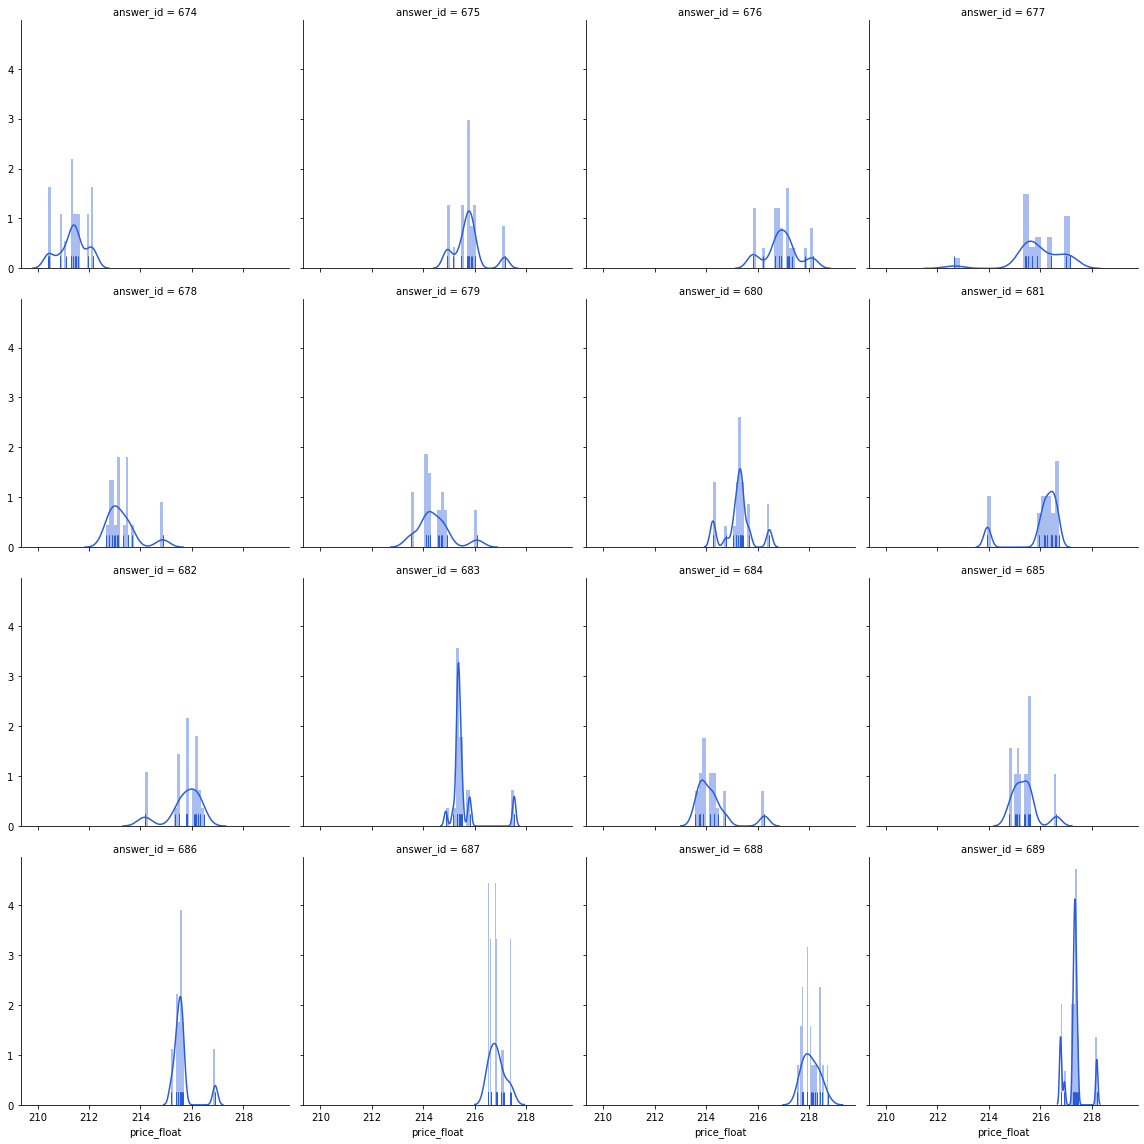

In [5]:
HOURS = 24

now = time.time()
print(now, convert_unixtime(now))
ts = now - timedelta(hours=HOURS).total_seconds()

# get last 16
lastn = 16
last_ans_id = max(df_responses[df_responses['timestamp']>=ts]['answer_id'])
df = df_responses[(df_responses['timestamp']>=ts) & (df_responses['answer_id']>last_ans_id-lastn)]

g = sns.FacetGrid(df, col="answer_id", col_wrap=4, height=4, aspect=1)
g.map(sns.distplot, "price_float", rug=True, **{'bins': 20, 'color': CHAINLINK_BLUE});

### Observations & Thoughts:
* We can't assume, based on these distributions, that we are always dealing with *normally distributed data*.
    * This is perhaps due to the fact that we have only ~20 responses. Fitting distributions to small data sets is always a problem. But perhaps there's something else going on here ...
* Often we'll see what appears to be a **multi/bi-modal distribution**.
    * Could this be a result of prices being reported from different exchanges? i.e. some nodes aren't aggregating reponses, instead they report from one or two sources?
        * I could test this hypothesis if I knew where the oracles were getting their data from.
        * **Idea**: Oracles that aggregate their responses from multiple exchanges are likely to have responses closer to the mean/median. Would penalizing oracles with responses further from the center of the distribution incentivize them to gather information from many sources (which is what we want)?
        * **Idea**: a weighted average of prices from exchanges, where the weight is a function(\*) of *trading volume* is a better aggregation method for price oracles than simple average. This is because prices reported from various exchanges, weighted by the trading volume of those exchanges, is clearly closer to what we envision as the "true price". How do we enforce/incentivise this? Idea: somehow incentivise both accurate (close to mean/median) responses as well as responses representing a large trading volume?
    * Could this be due to oracles reporting at different times within a round?
        * **This will be tested in a bit.**

(\*) I say *function of* trading volume, because the weighting should be proportional to trading volume, but not exactly equal to it due to interactions such as liquidity (e.g. trading volume is directly correlated with liquidity which has an effect on price.

## 1.1 Informal comparison to Gaussian<a class="anchor" id="1.1"></a>
One might assume that the irregularities with the above distributions is simply an artifact arising from a small sample ($n=21$, see table below). We can informally test this by plotting samples ($n=21$) from a *true* normal distribution and then do an informal, visually comparison to our plots above.

In [9]:
df = df_responses[['answer_id']].groupby(['answer_id']).agg(
    count_col=pd.NamedAgg(
        column="answer_id",
        aggfunc="count")
)
df.rename(columns={'count_col': 'n_oracles'}, inplace=True)

df.groupby(['n_oracles']).agg(
    count_col=pd.NamedAgg(
        column="n_oracles",
        aggfunc="count")
).rename(columns={'count_col': 'count'})

,count
n_oracles,
17,1
18,1
19,1
20,68
21,605
22,4
23,1
24,3
27,1


The large majority of the time we have 21 oracles responding.

In [10]:
N_SAMPLES = 16
df = generate_random_gaussians(21, N_SAMPLES)

Drawing 16 random samples (n=21) from Gaussian


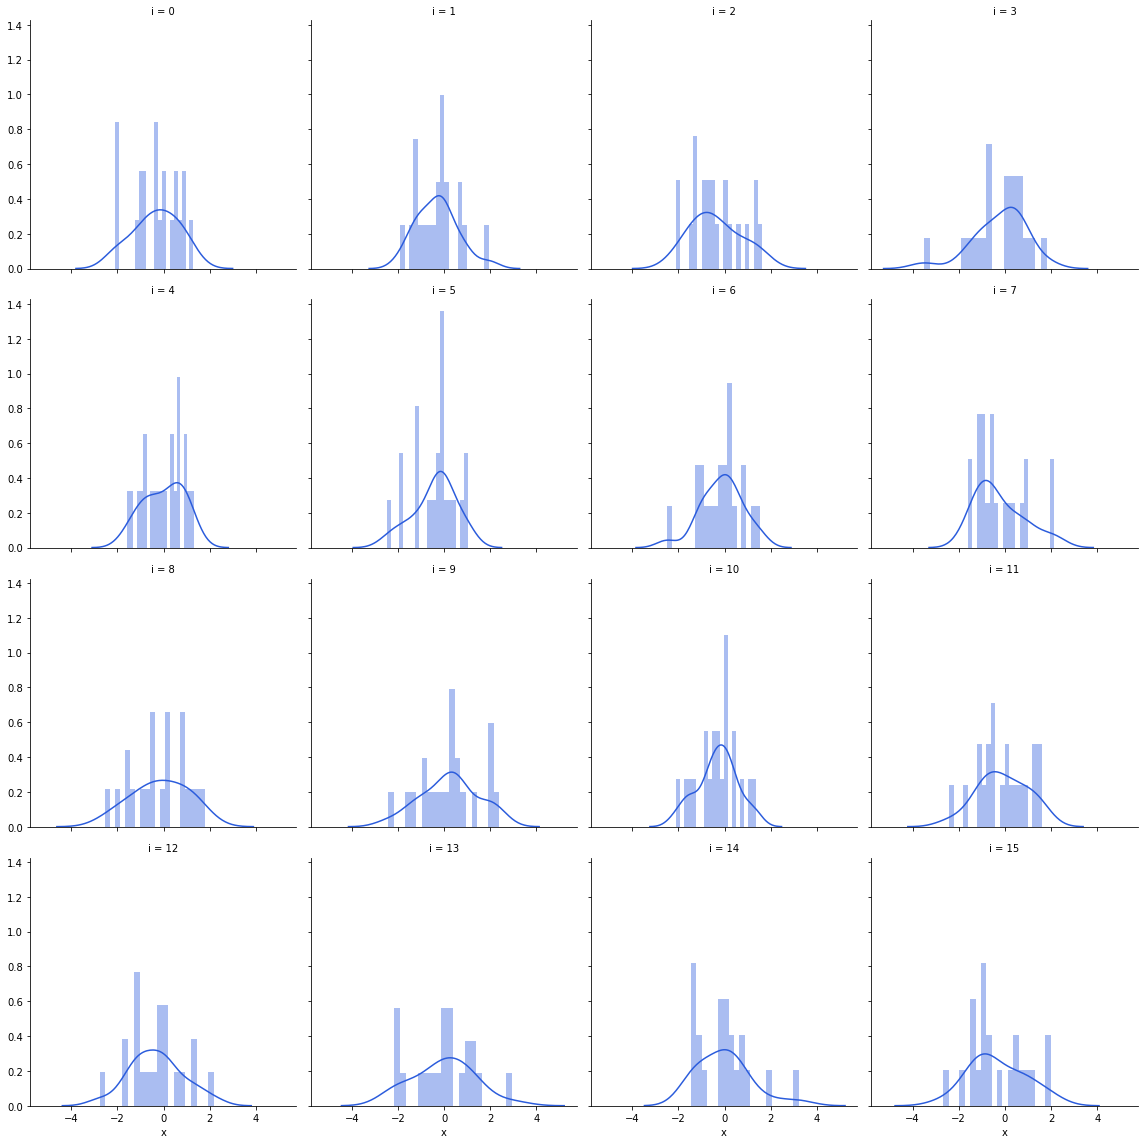

In [11]:
g = sns.FacetGrid(df, col="i", col_wrap=4, height=4, aspect=1)
g.map(sns.distplot, "x", **{'bins': 20, 'color': CHAINLINK_BLUE});

### Observations:
- We note, visually, that bimodal \& multimodal distributions are not that common in samples ($n = 21$) generated from true normal distributions, suggesting that there is some underlying factor for why our oracle response distributions are multimodal.

### Further comparison to Gaussian: Violin plots

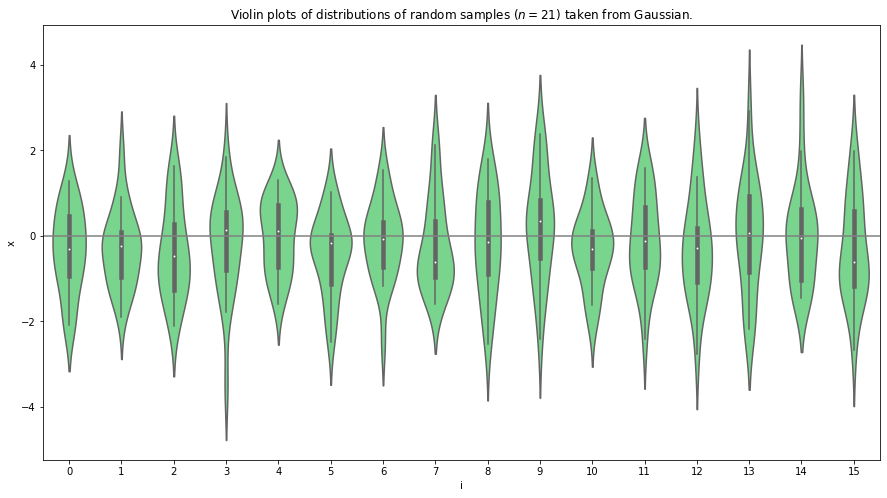

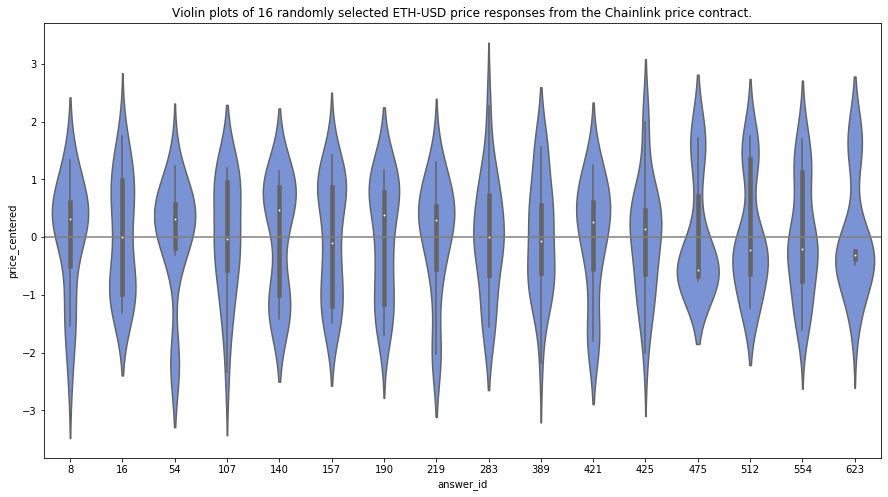

In [14]:
###
### violin plots for further visual study
###
f, ax = plt.subplots(1, 1, figsize=(15,8))
g = sns.violinplot(
    ax=ax,
    x="i",
    y="x", 
    height=1, aspect=1,
    color=GREEN,
    data=df
).set_title('Violin plots of distributions of random samples ($n=21$) taken from Gaussian.')
ax = g.axes
ax.axhline(0, color='grey');

# center data -> mean=0, std=1
df_responses.loc[:,'price_centered'] = df_responses.groupby('answer_id')['price_float'].transform(
    lambda x: (x - x.mean()) / x.std()
) 

# take a sample of previous rounds to simplify plotting
N_SAMPLES = 16
sample_ans_ids = df_responses['answer_id'].sample(N_SAMPLES)
df_sample = df_responses[df_responses['answer_id'].isin(sample_ans_ids)]

_, ax = plt.subplots(1, 1, figsize=(15,8))
g = sns.violinplot(
    ax=ax,
    x="answer_id",
    y="price_centered",
    height=1,
    aspect=1,
    color=CHAINLINK_BLUE_LIGHT,
    data=df_sample
).set_title('Violin plots of {} randomly selected ETH-USD price responses from the Chainlink price contract.'.format(N_SAMPLES))
ax = g.axes
ax.axhline(0, color='grey');

### Observations
* Note: the above distributions of price responses are centered (i.e. mean=0, std=1), so they hide any differences in variance between rounds. This is done so we can focus on the *shape* of the distributions.
* They look pretty okay, but let's focus on how they're different from samples drawn from normals.
     * They tend to be more skewed. See how the mode is rarely at the mean (compared to the true Gaussian distributions in green)? 
     * About half of the time, they tend to have a sperm-like appearance. Yes, that's a technical term. They typically have these long tails on one end.
* We will address potential reasons for why these response distributions are skewed and multimodal in proceeding sections where we look at the variance of the responses.

## 2. Exploring variance in responses<a class="anchor" id="2"></a>
We are interested in the variance of responses across rounds. We again compare to same-size samples drawn from a Gaussian.

### 2.1 A visual study<a class="anchor" id="2.1"></a>
We are interested in the variance of responses across rounds. We again compare to same-size samples drawn from a Gaussian.

In [20]:
NSAMPLES = 20
df_norm = generate_random_gaussians(21, NSAMPLES)

Drawing 20 random samples (n=21) from Gaussian


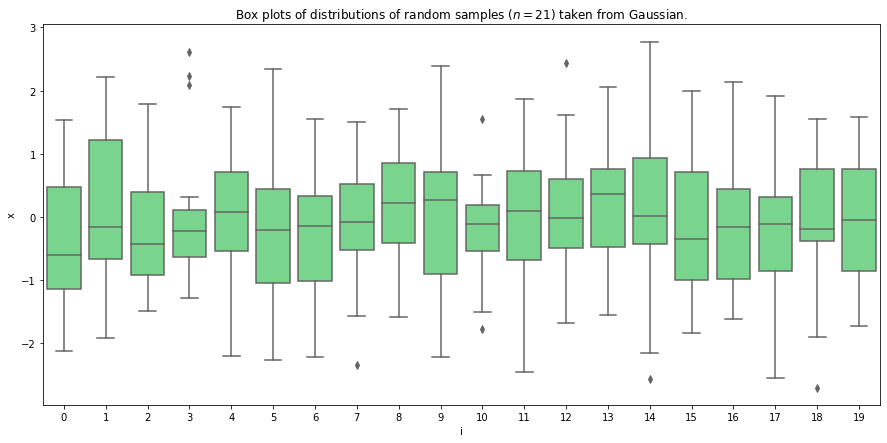

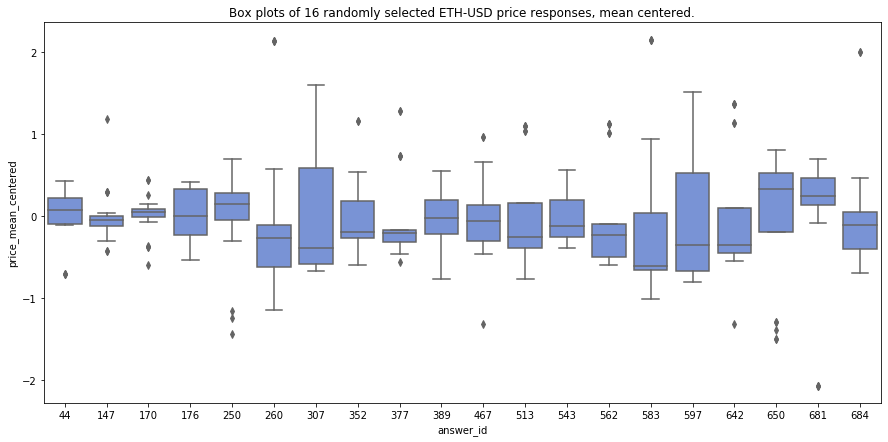

In [23]:
#
# plotting box plots for randomly selected rounds,
# and comparing them to Gaussians
#

### random samples from gaussian
_, ax = plt.subplots(1, 1, figsize=(15,7))
g = sns.boxplot(
    ax=ax,
    x="i",
    y="x",
    color=GREEN,
    data=df_norm
).set_title('Box plots of distributions of random samples ($n=21$) taken from Gaussian.'.format(N_SAMPLES))

# mean center -> mean=0, keep variace the same
# this is done so we can more easily compare differences in variance
df_responses.loc[:,'price_mean_centered'] = df_responses.groupby('answer_id')['price_float'].transform(
    lambda x: x - x.mean()
) 
# randomly select `NSAMPLES` rounds
sample_ans_ids = df_responses['answer_id'].sample(NSAMPLES)
df = df_responses[df_responses['answer_id'].isin(sample_ans_ids)]

_, ax = plt.subplots(1, 1, figsize=(15,7))
g = sns.boxplot(
    ax=ax,
    x="answer_id",
    y="price_mean_centered",
    color=CHAINLINK_BLUE_LIGHT,
    data=df
).set_title('Box plots of {} randomly selected ETH-USD price responses, mean centered.'.format(N_SAMPLES))

### Observations:
* First, note that the oracle responses are mean centered. This is done to emphasize the difference in variance between rounds.
* From an informal, visual inspection:
    * We have what appears might be a significant difference between variances in our oracle responses. Box plot ranges and IQRs appears to vary more than the gaussians (in green).
    * We again see some examples of a skew - the "line" in the box plot is often far from the center of the rectangle.
    * We see some clear outliers.

## 2.1 Exploring causes of variance
We analyze how the following factors affect the variance of oracle responses, for a given round:
* the length of a round
* variance of reporting times
* price volatility of asset (during the round)
How much do these factors influence the variability in responses.

### Getting the data

Price data.

In [24]:
### load price data gathered from the CryptoCompare API
df_prices = pd.read_csv('eth-usd_prices.csv', index_col=0)

In [25]:
df_prices

,time,high,low,open,volumefrom,volumeto,close
0,1587935700,197.01,196.59,197.01,579.44,113881.17,196.59
1,1587935760,196.71,196.56,196.65,403.38,79286.77,196.56
2,1587935820,196.69,196.58,196.61,276.62,54461.92,196.67
3,1587935880,196.72,196.65,196.67,136.90,26938.56,196.65
4,1587935940,196.69,196.61,196.65,805.18,158367.04,196.69
...,...,...,...,...,...,...,...
14396,1588037940,194.11,194.08,194.11,155.98,30273.02,194.10
14397,1588038000,194.06,193.98,194.10,438.46,85085.60,194.06
14398,1588038060,193.97,193.89,194.06,821.31,159308.54,193.97
14399,1588038120,193.79,193.71,193.97,1305.36,252862.42,193.71


Round metrics.

In [72]:
### load various metrics pertaining to a rounds
df_rounds = load_round_metrics(df_prices, df_responses)
df_rounds

Getting start times of rounds...
First block: 2020-04-29 18:02:09.
Round 690 USD-ETH price response: 2020-04-30 03:05:57.
Querying blockchain in chunks of 2000 blocks. 2 chunks total.



Done.
Converting block numbers to timestamps...



          block_number    ts_start      ts_end  round_length  response_std_ts  \
round_id                                                                        
2              9288036  1579122568  1586382065     7259497.0         5.516641   
3              9834003  1586381994  1586434893       52899.0        18.034887   
4              9837987  1586434798  1586438780        3982.0        33.924145   
5              9838260  1586438625  1586441008        2383.0        24.395647   
6              9838425  1586440886  1586447252        6366.0        17.028268   
...                ...         ...         ...           ...              ...   
693            9971587  1588218405  1588219505           NaN              NaN   
694            9971639  1588219252  1588219639           NaN              NaN   
695            9971647  1588219327  1588220261           NaN              NaN   
696            9971683  1588219990  1588221541           NaN              NaN   
697            9971808  158

/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [128]:
# removing clear outliers
# - the last two round haven't ended (`ts_end`=0) so we remove them
# - also, first two rounds are exeedingly long (probably some test runs)
df_rounds = df_rounds[(0 <= df_rounds['round_length']) & (df_rounds['round_length'] <= 6000)]
df_rounds = df_rounds[(0 <= df_rounds['response_std_price']) & (df_rounds['response_std_price'] <= 10)]
df_rounds = df_rounds[(0 <= df_rounds['response_std_ts']) & (df_rounds['response_std_ts'] <= 150)]
df_rounds
# TODO: don't remove entire rounds, remove responses with really long response times

,block_number,ts_start,ts_end,round_length,response_std_ts,response_std_price,volatility
round_id,,,,,,,
4,9837987,1586434798,1586438780,3982,33.924145,0.215972,NaN
5,9838260,1586438625,1586441008,2383,24.395647,0.179356,NaN
7,9838903,1586447154,1586448061,907,5.353682,0.314477,NaN
9,9839510,1586455205,1586458742,3537,16.867975,0.401519,NaN
10,9839786,1586458652,1586462511,3859,11.568430,0.367883,NaN
...,...,...,...,...,...,...,...
687,9970588,1588204818,1588208734,3916,6.766014,0.293885,0.759601
688,9970875,1588208679,1588210303,1624,22.887926,0.321153,0.320359
688,9970875,1588208679,1588210303,1624,22.887926,0.321153,0.320359


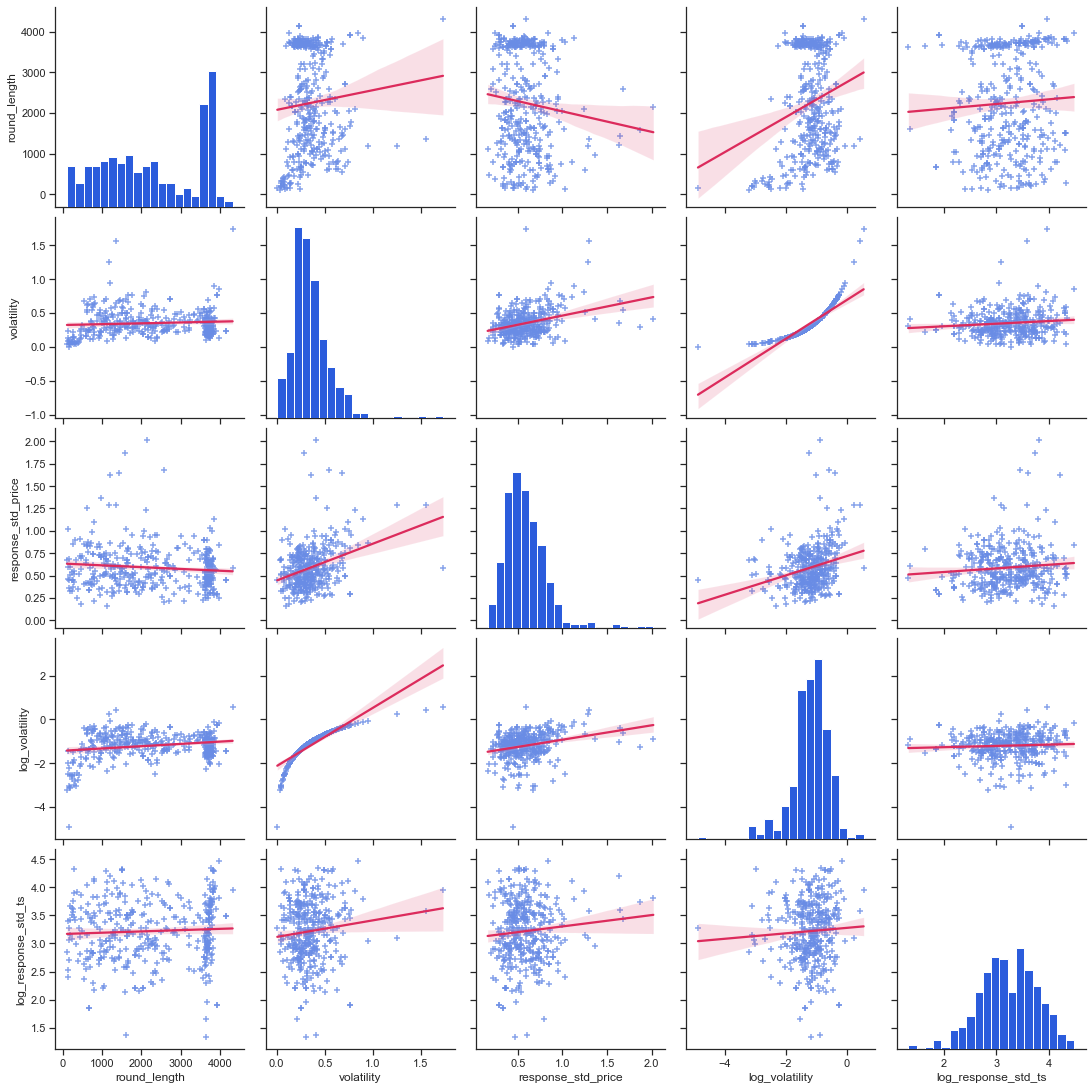

In [135]:
'''
adding some data:
- we don't want timestamps to be the only measure of response times
- timestamps are approximated from the block number where response is located
- want to also include "block distance"
'''
df = df_rounds[['round_length', 'volatility', 'response_std_price']]
# add log(volatility)
df['log_volatility'] = np.log(df_rounds['volatility'])
df['log_response_std_ts'] = np.log(df_rounds['response_std_ts'])
df = df.dropna()

sns.set(style="ticks", color_codes=True)
g = sns.pairplot(
    df, diag_kind="hist", kind="reg", markers="+", height=3,
    palette='Blues',
    diag_kws={'bins':20, 'color': CHAINLINK_BLUE},
    plot_kws={'color': CHAINLINK_BLUE_LIGHT, 'line_kws':{'color':RED}}
)

### Observations \& Comments
- we have multicollinearity
    - That's fine. These factors are clearly correlated (e.g. longer rounds are expected to have more price volatility). We are interested in explaining the variance in price responses *as a whole* not necessarily how much individual factors affect price (the only case in which multicollinearity would matter).
- all of our factors appear correlated to some degree
    - strongest correlation between price volatility and the standard deviation in prices resported by oracles for a given round

### Multivariate least squares regression

In [136]:
X = df[['round_length', 'volatility', 'log_response_std_ts']]
X = sm.add_constant(X)
y = df['response_std_price']

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     response_std_price   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     18.35
Date:                Thu, 30 Apr 2020   Prob (F-statistic):           4.08e-11
Time:                        01:59:10   Log-Likelihood:                 21.632
No. Observations:                 371   AIC:                            -35.26
Df Residuals:                     367   BIC:                            -19.60
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.4116      0.075      5.511      0.000       0.265       0.558
round_length        -2.605e-05   9.77e-06     -2.667      0.008   -4.53e-05   -6.84e-06
volatility              0.4158      0.061      6.845      0.000       0.296       0.535
log_response_std_ts     0.0277      0.022      1.258      0.209      -0.016       0.071
==============================================================================
Omnibus:                      163.065   Durbin-Watson:                   0.820
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1010.990
Skew:                           1.751   Prob(JB):                    2.93e-220
Kurtosis:                      10.290   Cond. No.                     1.69e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Rough Work

In [131]:
'''
adding some data:
- we don't want timestamps to be the only measure of response times
- timestamps are approximated from the block number where response is located
- want to also include "block distance"
'''
def block_distance(row):
    return df_rounds.loc[row['answer_id']].item() - row['blockNumber']
    
df_responses['block_distance_from_start'] = df_responses.apply(lambda row: block_distance(row))

KeyError: 'answer_id'

In [ ]:
def block_distance(row):
    return df_rounds.loc[row['answer_id']].item() - row['blockNumber']
df_responses['block_distance_from_start'] = df_responses.apply(lambda row: block_distance(row))

In [ ]:
df = df_rounds[['round_length', 'response_std_price', 'volatility']].dropna()
df['log_std_ts'] = np.log(df_rounds['response_std_ts'])

g = sns.pairplot(df)

In [87]:
df.corr()

,round_length,response_std_price,volatility,log_std_ts
round_length,1.000000,-0.087720,0.032928,0.028420
response_std_price,-0.087720,1.000000,0.432253,0.143114
volatility,0.032928,0.432253,1.000000,0.100283
log_std_ts,0.028420,0.143114,0.100283,1.000000


In [88]:
# R^2, just volatility
df = df_rounds[['round_length', 'response_std_price', 'volatility']].dropna()
df['log_std_ts'] = np.log(df_rounds['response_std_ts'])

# remove outliers
df = df.drop(533) # large price std
df = df.drop(530) # large price std
df = df.drop(379) # response after round
df = df.drop(380) # response after round
df = df.drop(381) # response after round

X = df[['volatility']]
X = sm.add_constant(X)
y = df['response_std_price']

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     response_std_price   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     65.49
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.71e-14
Time:                        16:49:10   Log-Likelihood:                -2.7554
No. Observations:                 287   AIC:                             9.511
Df Residuals:                     285   BIC:                             16.83
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3878      0.030     13.073      0.000       0.329       0.446
volatility     0.6005      0.074      8.092      0.000       0.454       0.747
==============================================================================
Omnibus:                      140.923   Durbin-Watson:                   0.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              823.577
Skew:                           1.954   Prob(JB):                    1.45e-179
Kurtosis:                      10.321   Cond. No.                         5.77
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- ignore individual coefficients due to multicollinearity
- most important r-squared: 85% of variance in responses can be explained by price volatility, round length, variance of response times
    - implies variance somewhat controllable: shorten rounds
    - extreme values context dependant

In [165]:
### getting price volatility ###
CRYPTO_COMPARE_API_URL = 'https://min-api.cryptocompare.com/data/v2/histominute?fsym=ETH&tsym=USD&toTs={ts}&limit={limit}'
KEY = 'a629da4917f3816b8575a64610ed94a857598d2835a75136d8c79ba35b753861'
headers = {'Apikey': KEY}

In [258]:
# PRICE VOLATILITY
### NOTE: ONLY AVAILABLE FOR LAST 7 DAYS ###
def get_prices(from_, to_, limit=30):
    res = {
        'time': [],
        'high': [],
        'low': [],
        'open': [],
        'close': []
    }
    # ignore volume data for now
    r = requests.get(CRYPTO_COMPARE_API_URL.format(ts=to_, limit=limit), headers=headers)
    d = json.loads(r.content.decode('utf-8'))
    for x in d['Data']['Data']:
        if x['time'] < from_:
            break
        for k in res.keys():
            res[k].append(x[k])
    else:
        # need to keep querying to get all data in range
        df = get_prices(from_, min(res['time']) - 1)
        return pd.concat([pd.DataFrame(res), df])
        
    return pd.DataFrame(res)

In [259]:
# we will use variance of price over period of time. price in minute will be mean of high, low, open, close
def volatility(ts):
    ### NOTE: ONLY AVAILABLE FOR LAST 7 DAYS ###
    if ts[0] > time.time() - 7 * 86400:
        df = get_prices(ts[0], ts[1])
        df['price'] = df[['high', 'low', 'open', 'close']].mean(axis=1)
        return df.price.std()
    else:
        return np.nan

In [112]:
#df_responses
df_responses

,price,answer_id,oracle,blockNumber,timestamp,date,price_float,price_centered,price_mean_centered
0,16631351520,1,0x0Ce0224ba488ffC0F46bE32b333a874Eb775c613,9288039,1579122628,2020-01-15 21:10:28,166.313515,0.428442,0.149352
1,16670000000,1,0x83dA1beEb89Ffaf56d0B7C50aFB0A66Fb4DF8cB1,9288039,1579122628,2020-01-15 21:10:28,166.700000,1.537143,0.535837
2,16643436950,1,0x7A9d706B2A3b54f7Cf3b5F2FcF94c5e2B3d7b24B,9288039,1579122628,2020-01-15 21:10:28,166.434370,0.775134,0.270206
3,16614295610,1,0x049Bd8C3adC3fE7d3Fc2a44541d955A537c2A484,9288039,1579122628,2020-01-15 21:10:28,166.142956,-0.060837,-0.021207
4,16563811450,1,0x79C6e11bE1C1ed4D91FbE05D458195A2677F14A5,9288039,1579122628,2020-01-15 21:10:28,165.638115,-1.509065,-0.526049
...,...,...,...,...,...,...,...,...,...
12870,19535000000,614,0x85aEace84a130bC1AcCcE2a9F4F933F6765b0B9B,9957773,1588033700,2020-04-28 00:28:20,195.350000,-0.677142,-0.401864
12871,19628886365,614,0x049Bd8C3adC3fE7d3Fc2a44541d955A537c2A484,9957773,1588033700,2020-04-28 00:28:20,196.288864,0.904845,0.536999
12872,19628886365,614,0x8cfb1D4269f0daa003CDEa567aC8f76c0647764a,9957773,1588033700,2020-04-28 00:28:20,196.288864,0.904845,0.536999
12873,19544250000,614,0xF5a3d443FccD7eE567000E43B23b0e98d96445CE,9957772,1588033685,2020-04-28 00:28:05,195.442500,-0.521279,-0.309364


In [213]:
def ts_percentile(row):
    rnd = int(row['answer_id'])
    return (row['timestamp'] - df_rounds.loc[rnd]['ts_start']) / df_rounds.loc[rnd]['round_length']

#print(list(range(2, df_responses['answer_id'].max(), 20)))
sample_ans_ids = list(range(2, df_responses['answer_id'].max(), 20))
df_sample = df_responses[df_responses['answer_id'].isin(sample_ans_ids)]
#df_sample = df_responses
df_response_ts = df_sample[['answer_id', 'price_centered', 'timestamp']]
df_response_ts = df_response_ts[df_response_ts.answer_id.isin(df_rounds.index)]
#df_response_ts['ts_percentile'] = df_response_ts.apply(lambda row: ts_percentile(row), axis=1)
df_response_ts['ts_rank_pct'] = df_response_ts.groupby(['answer_id']).\
    agg(
        count_col=pd.NamedAgg(column='timestamp', aggfunc="rank")
    ).\
    rename(columns={'count_col': 'ts_rank_pct'})

# remove outliers
#df_response_ts = df_response_ts[df_response_ts['ts_percentile'] <= 1]
'''
df_response_ts.drop(11170, inplace=True)
df_response_ts.drop(11093, inplace=True)
df_response_ts.drop(11094, inplace=True)
df_response_ts.drop(11095, inplace=True)
df_response_ts.drop(11096, inplace=True)
df_response_ts.drop(11097, inplace=True)
df_response_ts.drop(11098, inplace=True)
'''
#df_response_ts = df_response_ts[df_response_ts['price_mean_centered'].abs() < 3]

'\ndf_response_ts.drop(11170, inplace=True)\ndf_response_ts.drop(11093, inplace=True)\ndf_response_ts.drop(11094, inplace=True)\ndf_response_ts.drop(11095, inplace=True)\ndf_response_ts.drop(11096, inplace=True)\ndf_response_ts.drop(11097, inplace=True)\ndf_response_ts.drop(11098, inplace=True)\n'

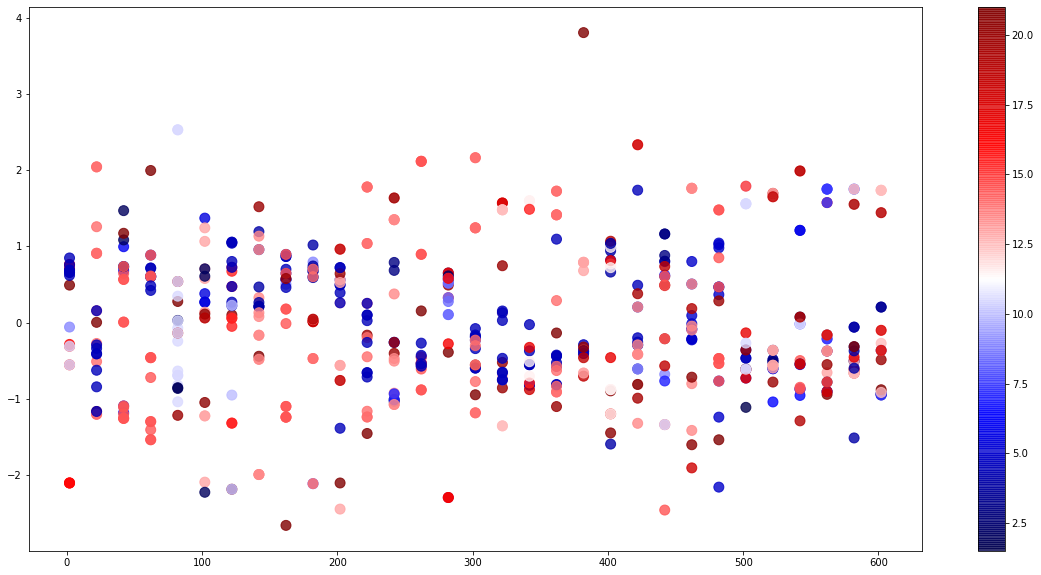

In [252]:
df = df_response_ts
plt.figure(figsize=(20, 10))
#cmap = ListedColormap(sns.diverging_palette(10, 220, sep=80, n=7))
cmap = plt.get_cmap('PiYG')
#s = [20*abs(11.25 - p) for p in df.ts_rank_pct] # further away from white -> bigger
plt.scatter(df.answer_id, df.price_centered, alpha = .8, c = df.ts_rank_pct, cmap='seismic', s=100)
cbar = plt.colorbar()

Observations:
- appears that nodes that respond later (in red) tend to be outliers, or near outlier "territory"
- interesting, because later responses we'd expect to be more accurate (closer to recent price) than earlier responses (assuming beneficient node)

In [260]:
# absolute distance from mean as function of rank
df_response_ts['price_centered_abs'] = df_response_ts['price_centered'].abs()

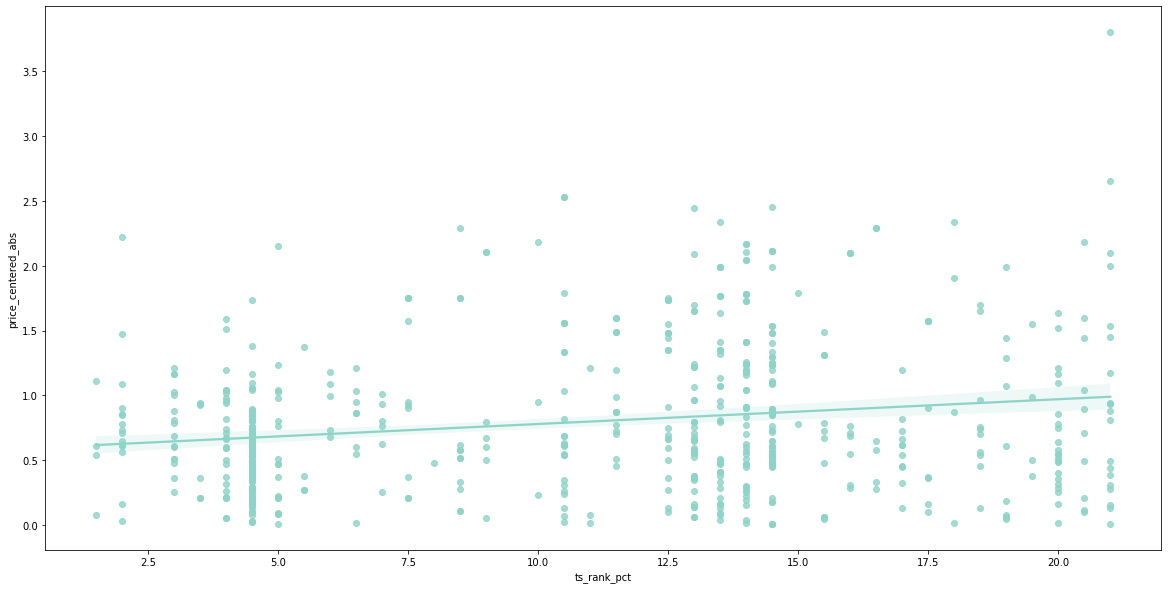

In [263]:
plt.figure(figsize=(20, 10))
sns.regplot(df_response_ts['ts_rank_pct'], df_response_ts['price_centered_abs'])

In [268]:
x = df_response_ts['ts_rank_pct']
y = df_response_ts['price_centered_abs']
result = stats.linregress(x,y)
result

LinregressResult(slope=0.019097912756610595, intercept=0.5888469933704286, rvalue=0.18865029915883108, pvalue=1.425080454410296e-06, stderr=0.003923665582418665)

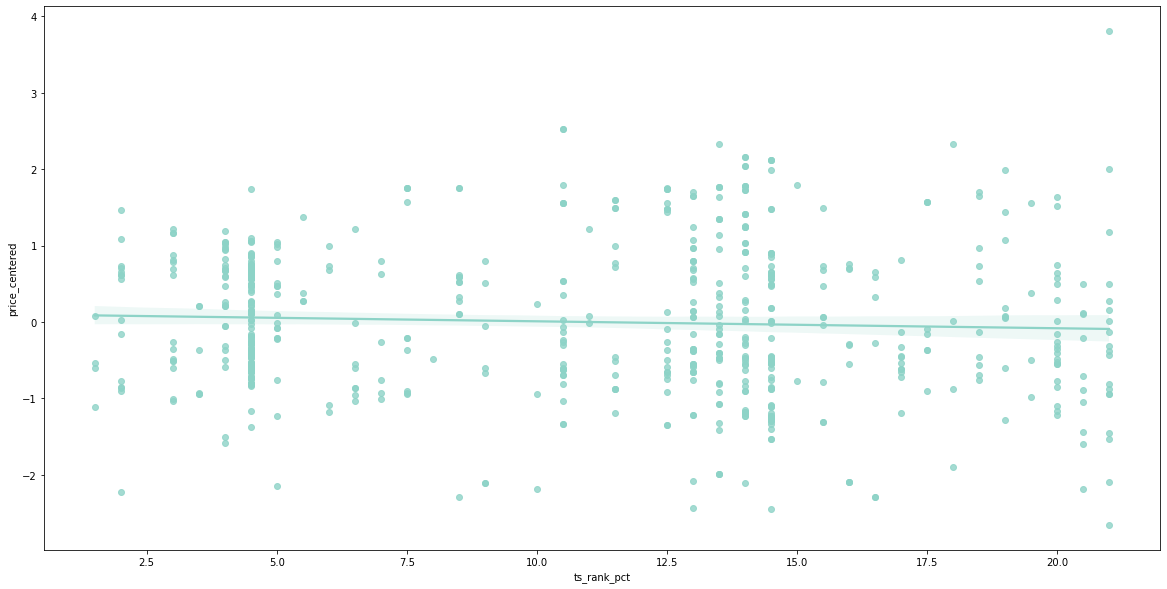

In [272]:
plt.figure(figsize=(20, 10))
sns.regplot(df_response_ts['ts_rank_pct'], df_response_ts['price_centered'])

In [273]:
x = df_response_ts['ts_rank_pct']
y = df_response_ts['price_centered']
result = stats.linregress(x,y)
result

LinregressResult(slope=-0.009095485381648224, intercept=0.09910406975627316, rvalue=-0.05182885339620363, pvalue=0.18898199315594857, stderr=0.006916759460337575)

There appears to also be a significant (pvalue ~= 0.007) relationship between the distance from the mean price (normalized to mean=0, std=1) reported by an oracle is correlated (pvalue ~= 1e-6) with the percentile rank of of the timestamp of the oracles response.

Summary:
* the absolute distance from the mean price (normalized to mean=0, std=1) reported by an oracle is correlated (correlation coefficient=.189; pvalue ~= 1e-6) with the percentile rank of of the timestamp of the oracles response.
* in more normal language: for a given round, the oracles that respond earliest and latest tend to be furthest from the mean response
* correlations from first and second both significant, but stronger relationship with first (larger slope value), 
    * **what this means**: ...
* I strongly feel that there would be a stronger relationship if we had accurate timestamps
Observations
* some correlation
* note that rank approximation is *extremely* crude -- approximated from block number, that's why goes up to 20.0 and not 100.0

In [340]:
# bucket responses by rank
# note: rank per round
nlabels = 3
df_response_ts['ts_bucket'] = df_response_ts.groupby('answer_id').ts_rank_pct.apply(pd.cut, bins=nlabels, labels=range(1, nlabels+1))

In [341]:
df_response_ts

,answer_id,price_centered,timestamp,ts_rank_pct,price_centered_abs,ts_bucket
21,2,0.764015,1586382044,4.5,0.764015,1
22,2,0.764015,1586382053,16.0,0.764015,3
23,2,-0.307108,1586382053,16.0,0.307108,3
24,2,0.710754,1586382053,16.0,0.710754,3
25,2,0.493827,1586382065,21.0,0.493827,3
...,...,...,...,...,...,...
12618,602,-0.361684,1588003338,17.5,0.361684,3
12619,602,-0.098842,1588003338,17.5,0.098842,3
12620,602,1.443282,1588003342,19.0,1.443282,3
12621,602,1.736224,1588003337,12.5,1.736224,2


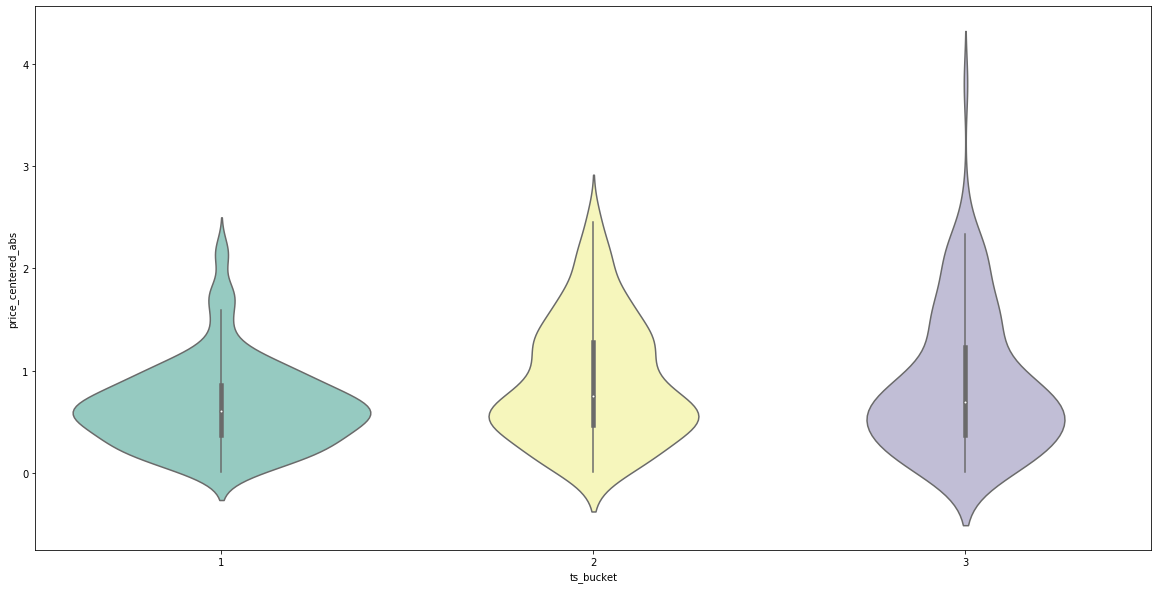

In [342]:
#palette = sns.diverging_palette(240, 10, n=nlabels)
df = df_response_ts[['ts_bucket', 'price_centered_abs']]
plt.figure(figsize=(20, 10))
sns.violinplot(x="ts_bucket", y="price_centered_abs", data=df)

# Outlier detection

Notes: IQR is great because we can assume at least 50% of nodes are honest

In [455]:
#TODO: undo
df_responses = df_responses[df_responses['answer_id'] > 2]

In [388]:
df_responses['price'] = df_responses['price_float']
df = df_responses[['answer_id', 'price_float']]
Q1 = df.groupby('answer_id').quantile(0.25)
Q3 = df.groupby('answer_id').quantile(0.75)

In [420]:
def is_outlier(row):
    id_ = row['answer_id']
    q1 = Q1.loc[id_].item()
    q3 = Q3.loc[id_].item()
    iqr = q3 - q1
    p = row['price_float']
    return p < q1 - 1.5*iqr or q3 + 1.5*iqr < p 

df_responses['outlier'] = df_responses.apply(lambda row: is_outlier(row), axis=1)
# add rank
df_responses['ts_rank_pct'] = df_responses.groupby(['answer_id']).agg(
    count_col=pd.NamedAgg(column='timestamp', aggfunc="rank")
)
df_responses.rename(columns={'count_col': 'ts_rank_pct'}, inplace=True)

In [452]:
df_rounds

,block_number,ts_start,ts_end,round_length,response_std_ts,response_std_price,volatility
round_id,,,,,,,
2,9288036,1579122568,1586382065,7259497,5.516641,0.422454,NaN
3,9834003,1586381994,1586434893,52899,18.034887,0.631536,NaN
4,9837987,1586434798,1586438780,3982,33.924145,0.215972,NaN
5,9838260,1586438625,1586441008,2383,24.395647,0.179356,NaN
6,9838425,1586440886,1586447252,6366,17.028268,0.268847,NaN
...,...,...,...,...,...,...,...
614,9957640,1588031988,1588033787,1799,35.020878,0.593471,NaN
615,9957771,1588033661,1588035690,2029,9.073772,0.369760,NaN
616,9957910,1588035616,1588037246,1630,33.082437,0.676926,NaN


In [453]:
def f(row):
    id_ = row['answer_id']
    return row['timestamp'] - df_rounds.loc[id_]['ts_start']
    
df_responses['scnds_after_round_start'] = df_responses.apply(lambda row: f(row), axis=1)
df_responses

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,price,answer_id,oracle,blockNumber,timestamp,date,price_float,price_centered,price_mean_centered,outlier,ts_rank_pct,ts_bucket,scnds_after_round_start
21,172.822500,2,0xF5a3d443FccD7eE567000E43B23b0e98d96445CE,9834005,1586382044,2020-04-08 21:40:44,172.822500,0.764015,0.322761,False,4.5,1,7259476.0
22,172.822500,2,0x58c69aFF4Df980357034eA98AaD35bbF78cBD849,9834008,1586382053,2020-04-08 21:40:53,172.822500,0.764015,0.322761,False,16.0,4,7259485.0
23,172.370000,2,0x83dA1beEb89Ffaf56d0B7C50aFB0A66Fb4DF8cB1,9834008,1586382053,2020-04-08 21:40:53,172.370000,-0.307108,-0.129739,False,16.0,4,7259485.0
24,172.800000,2,0xB92ec7D213a28e21b426D79EDe3c9BBcf6917c09,9834008,1586382053,2020-04-08 21:40:53,172.800000,0.710754,0.300261,False,16.0,4,7259485.0
25,172.708358,2,0x7A9d706B2A3b54f7Cf3b5F2FcF94c5e2B3d7b24B,9834009,1586382065,2020-04-08 21:41:05,172.708358,0.493827,0.208619,False,21.0,5,7259497.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12870,195.350000,614,0x85aEace84a130bC1AcCcE2a9F4F933F6765b0B9B,9957773,1588033700,2020-04-28 00:28:20,195.350000,-0.677142,-0.401864,False,5.0,1,1712.0
12871,196.288864,614,0x049Bd8C3adC3fE7d3Fc2a44541d955A537c2A484,9957773,1588033700,2020-04-28 00:28:20,196.288864,0.904845,0.536999,False,5.0,1,1712.0
12872,196.288864,614,0x8cfb1D4269f0daa003CDEa567aC8f76c0647764a,9957773,1588033700,2020-04-28 00:28:20,196.288864,0.904845,0.536999,False,5.0,1,1712.0
12873,195.442500,614,0xF5a3d443FccD7eE567000E43B23b0e98d96445CE,9957772,1588033685,2020-04-28 00:28:05,195.442500,-0.521279,-0.309364,False,1.5,1,1697.0


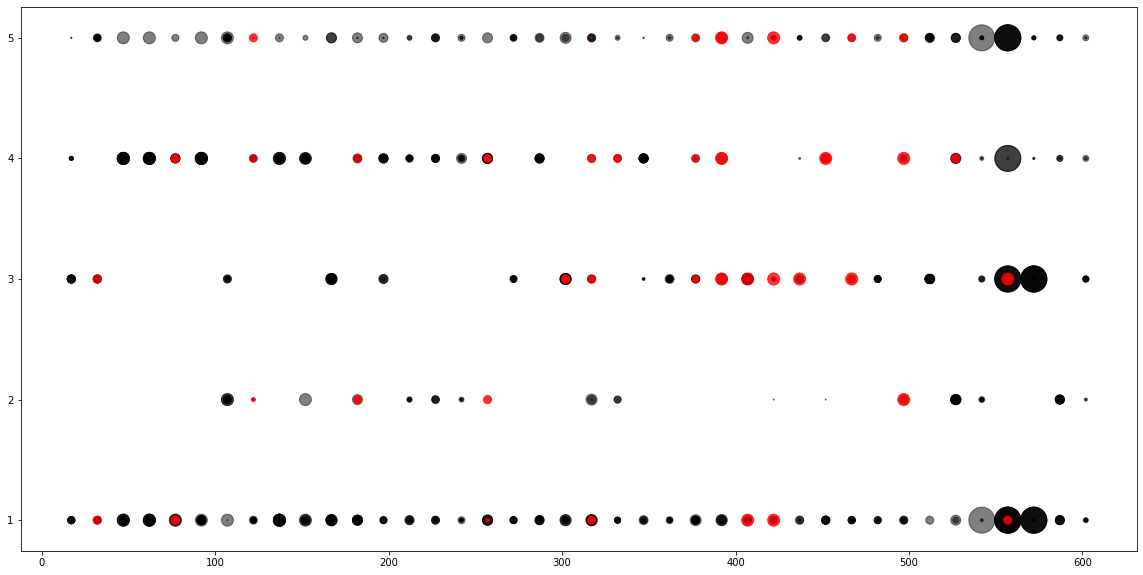

In [587]:
### NOTE: removing data points with extremely long response times (i.e. outliers wrt response time)
df = df_responses
df = df[df.scnds_after_round_start <= 10000]

plt.figure(figsize=(20, 10))
#cmap = ListedColormap(sns.diverging_palette(10, 220, sep=80, n=7))
cmap = ListedColormap(['black', 'red'])

### For better visuals, use only every nth rounds
n = 15
df = df_responses
ids = set(list(range(2, int(df['answer_id'].max()), n)))
df = df[df.isin({'answer_id': ids})['answer_id']]

# - many reponses per round share the same response time because response time 
#   is extrapolated from the mined block (i.e. very crude measure)
# - we make points that represent more than one response bigger, proportionally
counts = df.groupby(['answer_id', 'scnds_after_round_start', 'outlier']).agg(
    count_col=pd.NamedAgg(column='price', aggfunc="count")
)
s = []
for _,row in df.iterrows():
    c = counts.loc[(row['answer_id'], row['scnds_after_round_start'], row['outlier'])]['count_col']
    s.append(c**2)

# first layer (non-outliers)
df_ = df[~df['outlier']]
plt.scatter(
    df_.answer_id,
    df_.ts_bucket,
    alpha = .5,
    color='black',
    s=s
)

# second layer (outliers)
df_ = df[df['outlier']]
plt.scatter(
    df_.answer_id,
    df_.ts_bucket,
    alpha = .8,
    color='red',
    s=s
)

In [586]:
df

,price,answer_id,oracle,blockNumber,timestamp,date,price_float,price_centered,price_mean_centered,outlier,ts_rank_pct,ts_bucket,scnds_after_round_start
336,161.500000,17,0x83dA1beEb89Ffaf56d0B7C50aFB0A66Fb4DF8cB1,9842298,1586491731,2020-04-10 04:08:51,161.500000,-0.264039,-0.261375,False,11.5,3,454.0
337,163.249379,17,0x7e94A8A23687D8C7058Ba5625dB2Ce358bCbd244,9842298,1586491731,2020-04-10 04:08:51,163.249379,1.503170,1.488004,False,11.5,3,454.0
338,162.441566,17,0x2Ed7E9fCd3c0568dC6167F0b8aEe06A02CD9ebd8,9842298,1586491731,2020-04-10 04:08:51,162.441566,0.687124,0.680191,False,11.5,3,454.0
339,162.441566,17,0x24A718307Ce9B2420962fd5043fb876e17430934,9842298,1586491731,2020-04-10 04:08:51,162.441566,0.687124,0.680191,False,11.5,3,454.0
340,161.146615,17,0x79C6e11bE1C1ed4D91FbE05D458195A2677F14A5,9842298,1586491731,2020-04-10 04:08:51,161.146615,-0.621026,-0.614760,False,11.5,3,454.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12618,192.823750,602,0x64FE692be4b42F4Ac9d4617aB824E088350C11C2,9955464,1588003338,2020-04-27 16:02:18,192.823750,-0.361684,-0.297571,False,17.5,4,1933.0
12619,193.040000,602,0xF3b450002C7Bc300eA03c9463d8E8BA7f821b7c6,9955464,1588003338,2020-04-27 16:02:18,193.040000,-0.098842,-0.081321,False,17.5,4,1933.0
12620,194.308765,602,0x0Ce0224ba488ffC0F46bE32b333a874Eb775c613,9955465,1588003342,2020-04-27 16:02:22,194.308765,1.443282,1.187443,False,19.0,5,1937.0
12621,194.549779,602,0x38b6ab6B9294CCe1Ccb59c3e7D390690B4c18B1A,9955463,1588003337,2020-04-27 16:02:17,194.549779,1.736224,1.428458,False,12.5,3,1932.0


In [506]:
# TODO: blocknumber away

1024

In [593]:
df

outlier_count
answer_id scnds_after_round_start outlier               
3         52825.0                 False              0.0
          52837.0                 False              0.0
          52874.0                 False              0.0
          52899.0                 False              0.0
4         3835.0                  False              0.0
...                                                  ...
614       1712.0                  False              0.0
          1736.0                  False              0.0
          1756.0                  False              0.0
          1797.0                  False              0.0
          1799.0                  False              0.0

[3565 rows x 1 columns]

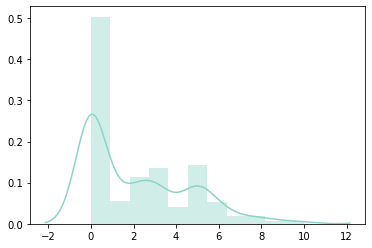

In [617]:
df = df_responses.groupby(['answer_id']).agg(
    count_col=pd.NamedAgg(column='outlier', aggfunc="sum"
))
df.rename(columns={'count_col': 'outlier_count'}, inplace=True)
sns.distplot(df)

NOTES:
* 1/2 the time, no outliers
* maximum outliers in any given round: 10

In [621]:
df[df['outlier_count'] == df['outlier_count'].max()]

,outlier_count
answer_id,
328,10.0
378,10.0
383,10.0
547,10.0


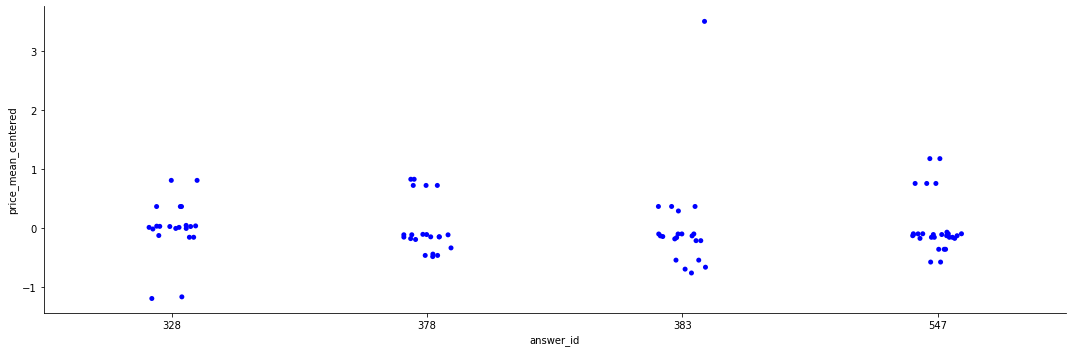

In [648]:
df = df_responses[df_responses.answer_id.isin([328, 378, 383, 547])]

sns.catplot(
    x="answer_id",
    y="price_mean_centered",
    data=df,
    height=5,
    aspect=3,
    color='blue'
);

In [624]:
df_responses.loc[[328, 378, 383, 547]]

,price,answer_id,oracle,blockNumber,timestamp,date,price_float,price_centered,price_mean_centered,outlier,ts_rank_pct,ts_bucket,scnds_after_round_start
328,162.038658,16,0x8cfb1D4269f0daa003CDEa567aC8f76c0647764a,9842283,1586491465,2020-04-10 04:04:25,162.038658,-0.500912,-0.705811,False,14.0,4,435.0
378,161.760000,19,0xF3b450002C7Bc300eA03c9463d8E8BA7f821b7c6,9842617,1586495883,2020-04-10 05:18:03,161.760000,-0.227355,-0.215560,False,14.0,3,2035.0
383,160.938504,19,0x7A9d706B2A3b54f7Cf3b5F2FcF94c5e2B3d7b24B,9842621,1586495904,2020-04-10 05:18:24,160.938504,-1.093805,-1.037056,False,21.0,5,2056.0
547,156.543319,27,0x8cfb1D4269f0daa003CDEa567aC8f76c0647764a,9845297,1586531669,2020-04-10 15:14:29,156.543319,-0.507374,-0.243472,False,3.0,1,4457.0


In [604]:
# when do outliers occur (which response percentile)
# are certain oracles producing more outliers?

In [371]:
Q1.loc[3].item()

168.61307380000005

In [ ]:

# Filtering Values between Q1-1.5IQR and Q3+1.5IQR
filtered = df.query('(@Q1 - 1.5 * @IQR) <= nb <= (@Q3 + 1.5 * @IQR)')

In [247]:
df_ts

,blockNumber,ts_start,ts_end
roundId,,,
2,9288036,1579122568,1586382065
3,9834003,1586381994,1586434893
8,9838959,1586448013,1586455311
7,9838903,1586447154,1586448061
6,9838425,1586440886,1586447252
...,...,...,...
451,9929879,1587660112,1587661345
450,9929687,1587657631,1587660214
449,9929611,1587656684,1587657899


In [217]:
pd.concat([std, pd.DataFrame(ts_range), pd.DataFrame(volatility)], axis=1)[300:350]

,timestamp,0,0
301,18.823684,1668.0,NaN
302,24.275441,1047.0,NaN
303,14.386785,111.0,NaN
304,21.940344,678.0,NaN
305,18.113149,688.0,NaN
306,11.801072,1006.0,NaN
307,18.012971,1466.0,NaN
308,30.607307,721.0,NaN
309,45.592298,1493.0,NaN
310,31.447036,1406.0,NaN


In [197]:
list(volatility)

[nan,
 nan,
 0.43752701812773864,
 0.3516386754390312,
 nan,
 nan,
 nan,
 0.5998629995920466,
 0.2063809375835104,
 nan,
 0.28541675625094376,
 nan,
 0.17668223709028097,
 nan,
 0.4426275558816957,
 0.1495517945305619,
 nan,
 nan,
 0.21871932964713084,
 0.3460196942862484,
 0.43751468485339673,
 nan,
 0.42211907813913596,
 nan,
 nan,
 nan,
 0.8318029792183705,
 nan,
 nan,
 0.35627083979793317,
 nan,
 nan,
 0.3475734624909632,
 0.25136779055605296,
 0.44011192637101054,
 0.3490745830279342,
 nan,
 0.1756271787451393,
 nan,
 nan,
 0.4971071286069257,
 nan,
 0.6993982987077689,
 0.2092933258289858,
 nan,
 nan,
 nan,
 0.3023001205809017,
 nan,
 0.42663346750037723,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.16806384795442356,
 nan,
 nan,
 0.44212311572950774,
 0.19915059580534497,
 0.13236445694507706,
 0.21826438417169988,
 0.33625039473135243,
 nan,
 nan,
 0.3541825549883321,
 nan,
 nan,
 nan]

In [153]:
list(volatility)

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

In [61]:
# amend dataframe

# variance as function of length of time (end - start)
df_std = df_answers.groupby(['answer_id']).\
    agg(
        count_col=pd.NamedAgg(column="price", aggfunc="std")
    ).\
    rename(columns={'count_col': 'price_std'})

df_std_ts = df_answers.groupby(['answer_id']).\
    agg(
        count_col=pd.NamedAgg(column="timestamp", aggfunc="std")
    ).\
    rename(columns={'count_col': 'ts_std'})

df_ = df_std.join(df_ts).join(df_std_ts)
df_['time_delta'] = df_.ts_end - df_.ts_start
# remove first 3 rows
df_ = df_.iloc[3:]
df_


,price_std,blockNumber,ts_start,ts_end,ts_std,time_delta
answer_id,,,,,,
4,2.159717e+07,9837987.0,1.586435e+09,1.586439e+09,33.924145,3982.0
5,1.793557e+07,9838260.0,1.586439e+09,1.586441e+09,24.395648,2383.0
6,2.688466e+07,9838425.0,1.586441e+09,1.586447e+09,17.028268,6366.0
7,3.144767e+07,9838903.0,1.586447e+09,1.586448e+09,5.353681,907.0
8,1.981088e+07,9838959.0,1.586448e+09,1.586455e+09,21.059214,7298.0
...,...,...,...,...,...,...
460,9.511251e+07,9931359.0,1.587680e+09,1.587683e+09,14.071755,2395.0
461,8.341454e+07,9931547.0,1.587683e+09,1.587683e+09,17.704048,629.0
463,6.963466e+07,9931710.0,1.587685e+09,1.587686e+09,53.609034,1383.0


In [140]:
# variance as function of length of time (end - start)
df_std = df_answers.groupby(['answer_id']).\
    agg(
        count_col=pd.NamedAgg(column="price", aggfunc="std")
    ).\
    rename(columns={'count_col': 'price_std'})

df_std_ts = df_answers.groupby(['answer_id']).\
    agg(
        count_col=pd.NamedAgg(column="timestamp", aggfunc="std")
    ).\
    rename(columns={'count_col': 'ts_std'})

df_ = df_std.join(df_ts).join(df_std_ts)
df_['time_delta'] = df_.ts_end - df_.ts_start
# remove first 3 rows
df_ = df_.iloc[3:]
df_

,price_std,blockNumber,ts_start,ts_end,ts_std,time_delta
answer_id,,,,,,
4,2.159717e+07,9837987.0,1.586435e+09,1.586439e+09,0.0,3982.0
5,1.793557e+07,9838260.0,1.586439e+09,1.586441e+09,0.0,2383.0
6,2.688466e+07,9838425.0,1.586441e+09,1.586447e+09,0.0,6366.0
7,3.144767e+07,9838903.0,1.586447e+09,1.586448e+09,0.0,907.0
8,1.981088e+07,9838959.0,1.586448e+09,1.586455e+09,0.0,7298.0
...,...,...,...,...,...,...
410,3.987064e+07,9924384.0,1.587587e+09,1.587589e+09,0.0,2399.0
411,2.904027e+07,9924559.0,1.587589e+09,1.587593e+09,0.0,3434.0
415,3.049482e+07,9925104.0,1.587596e+09,1.587600e+09,0.0,3737.0


In [132]:
df_answers

,price,answer_id,oracle,timestamp,date,price_float,price_centered,price_mean_centered
0,16631351520,1,0x0Ce0224ba488ffC0F46bE32b333a874Eb775c613,1.579123e+09,2020-01-15 21:10:28,166.313515,0.428442,0.149352
1,16670000000,1,0x83dA1beEb89Ffaf56d0B7C50aFB0A66Fb4DF8cB1,1.579123e+09,2020-01-15 21:10:28,166.700000,1.537143,0.535837
2,16614295610,1,0x049Bd8C3adC3fE7d3Fc2a44541d955A537c2A484,1.579123e+09,2020-01-15 21:10:28,166.142956,-0.060837,-0.021207
3,16563811450,1,0x79C6e11bE1C1ed4D91FbE05D458195A2677F14A5,1.579123e+09,2020-01-15 21:10:28,165.638115,-1.509065,-0.526049
4,16643715000,1,0x4565300C576431e5228e8aA32642D5739CF9247d,1.579123e+09,2020-01-15 21:10:28,166.437150,0.783111,0.272987
...,...,...,...,...,...,...,...,...
373,18316583767,415,0x4565300C576431e5228e8aA32642D5739CF9247d,1.587600e+09,2020-04-23 00:02:25,183.165838,1.001188,0.305310
374,18293379251,415,0x85aEace84a130bC1AcCcE2a9F4F933F6765b0B9B,1.587600e+09,2020-04-23 00:02:25,182.933793,0.240255,0.073265
375,18293379251,415,0x8cfb1D4269f0daa003CDEa567aC8f76c0647764a,1.587600e+09,2020-04-23 00:02:25,182.933793,0.240255,0.073265
376,18279000000,415,0xF5a3d443FccD7eE567000E43B23b0e98d96445CE,1.587600e+09,2020-04-23 00:02:25,182.790000,-0.231276,-0.070527


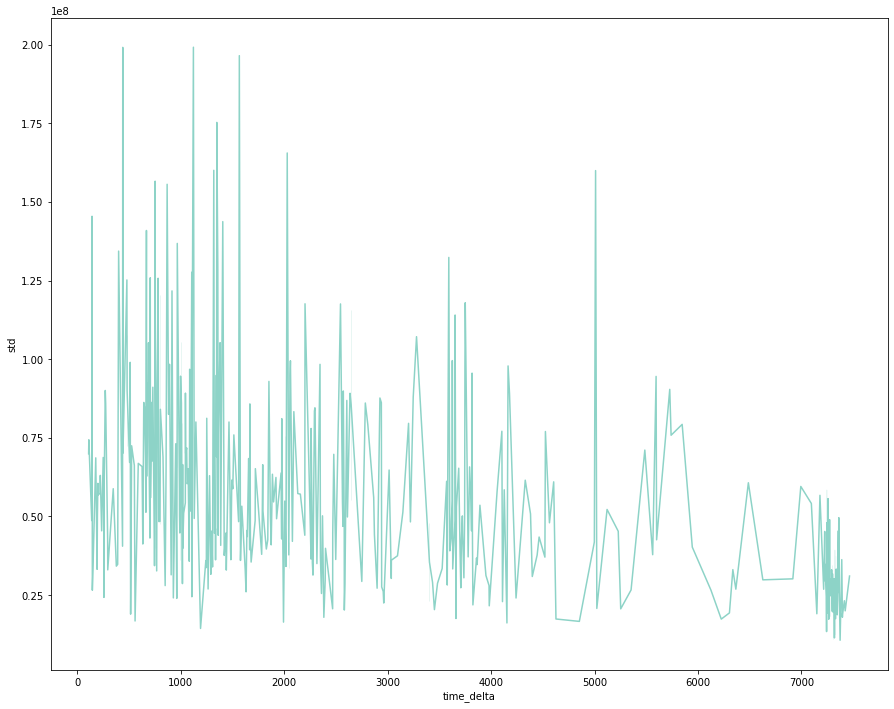

In [131]:
f, ax = plt.subplots(1, 1, figsize=(15,12))
sns.lineplot(ax=ax, x='time_delta', y='std', data=df_)

# Quick Ref

In [ ]:
WEB3, CONTRACT = connect()

block = web3.eth.getBlock('latest')['number']

#filter_ = CONTRACT.function.getTimestamp(1).call()

#entries = filter_.get_all_entries()
#entries
CONTRACT.functions.getTimestamp(1).call()

In [171]:
block = web3.eth.getBlock('latest')['number']
block

9930337

3.1. Investigating potential causes of bimodal distribution:
- Certain oracles?
- Reporting at different times?
- Price volatility

Addressing the hypothesis that variance between oracle reponses is largely due to price volatility in the time frame in which the price oracle is reporting.

In [264]:
WEB3, CONTRACT = connect()

start = approx_earliest_eth_block(2)['number']
end = approx_earliest_eth_block(3)['number']

entries = get_all_entries(
    CONTRACT.events.ResponseReceived(),
    start,
    last_block=end,
    query=(
        ['blockNumber'],
    ),
    chunk_size=500
)

15
1
0
0
First block: 2020-04-08 20:54:32.
Round 2 USD-ETH price response: 2020-04-08 21:41:05.
14
2
0
First block: 2020-04-09 07:22:29.
Round 3 USD-ETH price response: 2020-04-09 12:21:33.
Querying blockchain in chunks of 500 blocks. 5 chunks total.


AttributeDict({'args': AttributeDict({'response': 17270835810, 'answerId': 2, 'sender': '0x7A9d706B2A3b54f7Cf3b5F2FcF94c5e2B3d7b24B'}), 'event': 'ResponseReceived', 'logIndex': 37, 'transactionIndex': 41, 'transactionHash': HexBytes('0x458d767c28da54832855468c17a462547dce638f402605d8b6f1efc353db5eb9'), 'address': '0xF79D6aFBb6dA890132F9D7c355e3015f15F3406F', 'blockHash': HexBytes('0xd8cc708670217fa869fb86dc2ba2c9e729d6b7d7fcd3ad1eb4915cf5ed3a31f0'), 'blockNumber': 9834009})
t ['blockNumber']
k blockNumber
AttributeDict({'args': AttributeDict({'response': 17161291524, 'answerId': 2, 'sender': '0x38b6ab6B9294CCe1Ccb59c3e7D390690B4c18B1A'}), 'event': 'ResponseReceived', 'logIndex': 37, 'transactionIndex': 23, 'transactionHash': HexBytes('0xf973da0ef8f8b1f4cc6b4dc374883bc7d3e98b54cb5a7abfc5db04abacf8edcd'), 'address': '0xF79D6aFBb6dA890132F9D7c355e3015f15F3406F', 'blockHash': HexBytes('0x5daf20fcc31d6e9ef6737ead41476335a3119836cdc4f0dfc29ac229f24eef8f'), 'blockNumber': 9834008})
t ['blockN


Done.


In [ ]:
def median(x):
    n = len(x)
    if n % 2 == 1:
        return x[n//2]
    else:
        return (x[n//2] + x[n//2 + 1]) / 2 

In [ ]:
# get start times of Chainlink requests
entries = get_all_entries(
    contract.events.NewRound(),
    FIRST_BLOCK,
    query=[('blockNumber',), ('args', 'roundId')],
    chunk_size=1000
)
df_startblocks = pd.DataFrame(entries)

# get end times of Chainlink requests
entries = get_all_entries(
    contract.events.AnswerUpdated(),
    FIRST_BLOCK,
    query=[('args', 'roundId'), ('args', 'timestamp')],
    chunk_size=1000
)
df_endtimes = pd.DataFrame(entries)

In [ ]:
sns.distplot(skews, bins=30)

In [245]:
for f in contract.functions:
    print(f)

cancelRequest
authorizedRequesters
jobIds
latestAnswer
minimumResponses
oracles
transferLINK
latestRound
chainlinkCallback
renounceOwnership
updateRequestDetails
latestTimestamp
destroy
owner
getAnswer
getTimestamp
paymentAmount
requestRateUpdate
setAuthorization
transferOwnership


In [184]:
for event in contract.events:
    print(event)

<class 'web3._utils.datatypes.ResponseReceived'>
<class 'web3._utils.datatypes.OwnershipRenounced'>
<class 'web3._utils.datatypes.OwnershipTransferred'>
<class 'web3._utils.datatypes.ChainlinkRequested'>
<class 'web3._utils.datatypes.ChainlinkFulfilled'>
<class 'web3._utils.datatypes.ChainlinkCancelled'>
<class 'web3._utils.datatypes.AnswerUpdated'>
<class 'web3._utils.datatypes.NewRound'>


In [195]:
pd.DataFrame(entries)

,current,roundId,timestamp,blockNumber
0,18131297305,412,1587592990,9924834
1,18131917974,412,1587592950,9924831
2,18131297305,412,1587592950,9924831
3,18131917974,412,1587592935,9924829
4,18132538644,412,1587592935,9924829
...,...,...,...,...
348,18808754668,450,1587660200,9929885
349,18814000000,450,1587660200,9929885
350,18820523085,450,1587660161,9929883
351,18827046170,450,1587660149,9929882


In [ ]:
for _ in range(10):
    plt.figure()
    x = np.random.normal(scale=2, size=21)
    sns.distplot(x, bins=12)

# Conclusion
- What is the application? Daily average versus high-frequency trading? Is HFT even possilble as a blockchain application? Is that even a good thing or a bad thing? I digress ....
- Moonshot ideas: somehow incentivise oracles to respond at the same time
- oracles that respond later tend to be outliers, or closest to "outlier territory"
- all depends on context (high-frequency, vs average per day). There's a lot of subtelty here.